# LSTM - bert64

- **Training set**: LO_SARD102(0.6 split)
- **Test/Validation set:** LO_SARD102 (0.2 split)
- **Features**: bert sequence (64)
- **Class imbalance processing**: undersampling

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

X = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD102_bert64_X.npy')
y = pd.read_hdf('/mnt/md0/user/scheuererra68323/LOSARD102_bert64_y.h5').is_vulnerable.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.25, random_state=10)

del X
del y

print("class counts data set before undersampling:", Counter(Y_train))
print(X_train.shape)
print(Y_train.shape)


# undersample class 0
X_train, Y_train = undersample( np.reshape(X_train, (-1, 64*768) ), Y_train)
X_train = np.reshape(X_train, (-1, 64, 768))
print("class counts undersampled data set:", Counter(Y_train))

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

class counts data set before undersampling: Counter({0: 11742, 1: 231})
(11973, 64, 768)
(11973,)
class counts undersampled data set: Counter({0: 231, 1: 231})
(462, 64, 768)
(462,)
(3991, 64, 768)
(3991,)
(3991, 64, 768)
(3991,)


In [20]:
def run_classifier(_X_train, _Y_train, _X_val, _Y_val):
    
    model = keras.Sequential()
    model.add(layers.LSTM(64, input_shape=(_X_train.shape[1], _X_train.shape[2]), 
                          return_sequences=True))
    model.add(layers.Dropout(0.1))
    model.add(layers.LSTM(16, return_sequences=True))
    model.add( layers.TimeDistributed(layers.Dense(16)) )
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    
    history = model.fit(_X_train, _Y_train,
                        batch_size=32,
                        epochs=6,
                        verbose=True,
                        validation_data=(_X_val, _Y_val)
                        )
    
    return model, history


modelv2, historyv2 = run_classifier(X_train, Y_train, X_val, Y_val)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64, 64)            213248    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64, 16)            5184      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 64, 16)            272       
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1025      
Total params: 219,729
Trainable params: 219,729
Non-trainable params: 0
________________________________________________

In [ ]:
def evaluate_classifier(_model, _history):
    Y_pred = numpy.round(_model.predict(X_test))

    print(classification_report(Y_test, Y_pred))
    print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
    print()
    score = _model.evaluate(X_test, Y_test, verbose=False)
    print('Test loss:\t{:.6f}'.format(score[0]))
    print('Test accuracy:\t{:.6f}'.format(score[1]))

    plot_loss(_history)
    plot_accuracy(_history

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3914
           1       0.89      1.00      0.94        77

    accuracy                           1.00      3991
   macro avg       0.94      1.00      0.97      3991
weighted avg       1.00      1.00      1.00      3991

Confusion matrix:
[[3904   10]
 [   0   77]]

Confusion matrix (Percentages):
[[97.82   0.251]
 [ 0.     1.929]]

Metrics:
Sensitivity (TPR): 1.000000
Specifity (TNR):   0.997445

FPR: 0.002555
FNR: 0.000000

Balanced accuracy: 0.998723

Test loss:	0.011139
Test accuracy:	0.997494


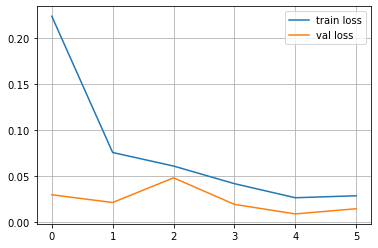

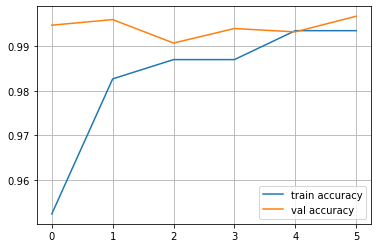

In [17]:
evaluate_classifier(modelv2, historyv2)

In [21]:
modelv2.save('LSTM_bert64_undersample')
modelv2.save('LSTM_bert64_undersample.h5')

INFO:tensorflow:Assets written to: LSTM_bert64_undersample/assets


INFO:tensorflow:Assets written to: LSTM_bert64_undersample/assets
